### Download Sentinel-1 data

Get all images from 2023 - 2024 IW, GRD, VV polarization, high resolution at buoy locations

In [1]:
# Import modules
import ee 
import geemap
import math
import numpy as np
import pandas as pd
import os
import glob 
import zipfile
import seaborn as sns
import rioxarray
import geopandas as gpd
import os

# Set home directory
home = "C:/Users/kmcquil/Documents/SWOT_WIND/"

In [3]:
# GEE authenticate
ee.Authenticate()


Successfully saved authorization token.


In [2]:
# GEE initialize
ee.Initialize()

In [3]:
# Filter the image collection 
# Load the sentinel 1 dataset and filter to GRD, IW, and VV polarization, years 2023-2024, and intersects with buoy locations 
buoys_shp_fp = os.path.join(home, "Data/Buoy/buoy_info.shp")
buoys = geemap.shp_to_ee(buoys_shp_fp)

start_date = '2023-01-01'
end_date = '2024-04-01'

sentinel1_vv = ee.ImageCollection('COPERNICUS/S1_GRD').filter(ee.Filter.eq('instrumentMode', 'IW')) \
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
.filter(ee.Filter.date(start_date, end_date)) \
.filter(ee.Filter.eq('resolution', 'H')) \
.filterBounds(buoys)

count = sentinel1_vv.size()
count

In [10]:
# Convert to type double for both bands so that they can be exported together 
def double(image):
    return image.double()
sentinel1_vv = sentinel1_vv.map(double)

In [11]:
# Export image collection to drive 
# change the scale to 100m 
# I exported this to kmcquillan449@gmail.com since I payed for 1TB of stroage
geemap.ee_export_image_collection_to_drive(sentinel1_vv, folder='S1', scale=100, maxPixels=10000000000000)

Total number of images: 1373



In [16]:
# Create a panda dt of the S1 image id, orbit direction, and orbit heading 
def get_properties(image):
    # Extract the system:id 
    id = image.get('system:id').getInfo()

    # Extract orbit direction 
    orbit_pass = image.get('orbitProperties_pass').getInfo()

    # Find the most eastern, most southern, and most northern point 
    coords = image.get('system:footprint').getInfo()['coordinates']
    x = [i[0] for i in coords]
    y = [i[1] for i in coords]

    east_idx = x.index(max(x))
    east_coord = coords[east_idx]

    south_idx = y.index(min(y))
    south_coord = coords[south_idx]

    north_idx = y.index(max(y))
    north_coord = coords[north_idx]

    if orbit_pass == "ASCENDING":
        # from east to north 
        angle = math.degrees(math.atan2(north_coord[1]-east_coord[1], north_coord[0]-east_coord[0]))
        orbit_heading = (90-angle)%360

    if orbit_pass == "DESCENDING":
        # from east to south 
        angle = math.degrees(math.atan2(south_coord[1]-east_coord[1], south_coord[0]-east_coord[0]))
        orbit_heading = (90-angle)%360

    dt = pd.DataFrame({'id':[id], 'orbit_pass':[orbit_pass], 'orbit_heading':[orbit_heading]})
    return dt 

# Convert to list for iteration 
s1_props = []
sentinel1_vv_list = sentinel1_vv.toList(count)
for i in range(0,len(sentinel1_vv_list)):
    image = ee.Image(ee.List(sentinel1_vv_list).get(i))
    s1_props.append(get_properties(image))

s1_props_df = pd.concat(s1_props)
s1_props_df.to_csv(os.path.join(home, "Data/Sentinel1/s1_image_info.csv"))

<Axes: xlabel='orbit_heading', ylabel='Count'>

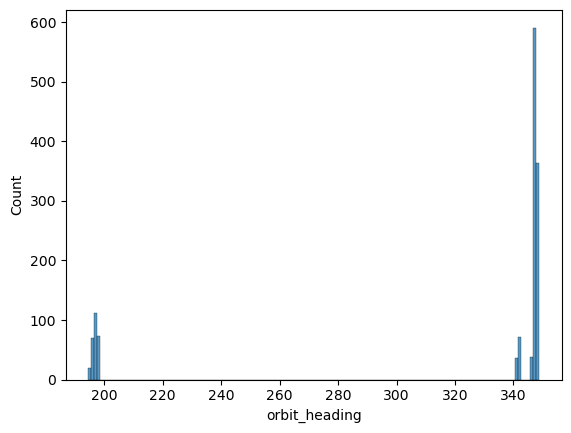

In [26]:
# Visualize the orbit headings 
sns.histplot(s1_props_df['orbit_heading'])

In [ ]:
# Map the footprint 
coords = image.get('system:footprint').getInfo()
system_footprint = ee.Geometry.LinearRing(coords['coordinates'])

Map = geemap.Map()
Map.addLayer(system_footprint, {}, "Footprint")
Map

In [24]:
# After downloading all of the sentinel 1 data from personal GDRIVE, it must be unzipped and put in the right location 
zip_files = glob.glob('C:/Users/kmcquil/Downloads/S1-*.zip')
for file in zip_files:
    with zipfile.ZipFile(file, 'r') as zip_ref:
        zip_ref.extractall(os.path.join(home, "Data/Sentinel1/Raw"))

In [3]:
# Process all of the sentinel images downloaded to linear units 
def process_sentinel(vv_fp):

    # Open and rename bands of the file 
    ds = rioxarray.open_rasterio(vv_fp, band_as_variable = True)
    ds = ds.rename({'band_1': 'sig0', 'band_2':'vh', 'band_3': 'inc_angle'})

    # Drop the vh band 
    ds = ds.drop_vars('vh')

    # Convert the vv sigma0 from dB to linear 
    ds['sig0'] = 10 ** (ds['sig0']/10)

    # Set the no data value
    ds.sig0.rio.write_nodata(np.nan, encoded=True, inplace=True)
    ds.inc_angle.rio.write_nodata(np.nan, encoded=True, inplace=True)

    # There is no water mask. This dataset will just use the lake boundary to mask out non-water pixels 
    # Add the platform heading as an attribute 
    orbit_heading = s1_props_df[s1_props_df['id'].str.contains(os.path.basename(vv_fp)[:-4])]['orbit_heading'].iloc[0]
    ds.rio.update_attrs({'platform_heading':orbit_heading}, inplace=True)
    # Write the crs again because it gets lost 
    ds.rio.write_crs(ds.rio.crs, inplace=True)
    # Save as a .nc file to preserve the platform_heading attribute 
    ds.to_netcdf(os.path.join(home, "Data/Sentinel1/Processed",  os.path.basename(vv_fp)[:-4] + ".nc"))
    ds.close()
    return "finished " + vv_fp


In [4]:
s1_props_df = pd.read_csv(os.path.join(home, "Data/Sentinel1/s1_image_info.csv"))
s1_files = glob.glob(os.path.join(home, "Data/Sentinel1/Raw/S1/*.tif"))

for file in s1_files:
    if os.path.isfile(os.path.join(home, "Data/Sentinel1/Processed",  os.path.basename(file)[:-4] + ".nc")) == True:
        continue
    process_sentinel(file)

## Retrieve S1 images centered 5x5 km around buoys at 10-m resolution

In [4]:
# Functions to apply the refined lee filter 
def db_to_power(img):
    """Function to convert SAR units from dB to power

    args:
        img (ee.Image): SAR dB image to convert to power

    returns:
        ee.Image: power SAR image
    """
    return ee.Image(10).pow(img.divide(10))

def power_to_db(img):
    """Function to convert SAR units from power to dB

    args:
        img (ee.Image): SAR power image to convert to dB

    returns:
        ee.Image: dB SAR image
    """
    return ee.Image(10).multiply(img.log10())

def refined_lee(image, keep_bands=["angle"]):
    """Refined Lee speckle filtering algorithm.
    # Code from HYDRAFloods: https://servir-mekong.github.io/hydra-floods/algorithms/
    Algorithm adapted from https://groups.google.com/g/google-earth-engine-developers/c/ExepnAmP-hQ/m/7e5DnjXXAQAJ

    args:
        image (ee.Image): Earth engine image object. Expects that imagery is a SAR image

    returns:
        ee.Image: filtered SAR image using the Refined Lee algorithm
    """
    def apply_filter(b):
        """Closure function to apply the refined lee algorithm on individual bands"""
        b = ee.String(b)
        img = power.select(b)

        # img must be in natural units, i.e. not in dB!
        # Set up 3x3 kernels
        weights3 = ee.List.repeat(ee.List.repeat(1, 3), 3)
        kernel3 = ee.Kernel.fixed(3, 3, weights3, 1, 1, False)

        mean3 = img.reduceNeighborhood(ee.Reducer.mean(), kernel3)
        variance3 = img.reduceNeighborhood(ee.Reducer.variance(), kernel3)

        # Use a sample of the 3x3 windows inside a 7x7 windows to determine gradients and directions
        sample_weights = ee.List(
            [
                [0, 0, 0, 0, 0, 0, 0],
                [0, 1, 0, 1, 0, 1, 0],
                [0, 0, 0, 0, 0, 0, 0],
                [0, 1, 0, 1, 0, 1, 0],
                [0, 0, 0, 0, 0, 0, 0],
                [0, 1, 0, 1, 0, 1, 0],
                [0, 0, 0, 0, 0, 0, 0],
            ]
        )

        sample_kernel = ee.Kernel.fixed(7, 7, sample_weights, 3, 3, False)

        # Calculate mean and variance for the sampled windows and store as 9 bands
        sample_mean = mean3.neighborhoodToBands(sample_kernel)
        sample_var = variance3.neighborhoodToBands(sample_kernel)

        # Determine the 4 gradients for the sampled windows
        gradients = sample_mean.select(1).subtract(sample_mean.select(7)).abs()
        gradients = gradients.addBands(
            sample_mean.select(6).subtract(sample_mean.select(2)).abs()
        )
        gradients = gradients.addBands(
            sample_mean.select(3).subtract(sample_mean.select(5)).abs()
        )
        gradients = gradients.addBands(
            sample_mean.select(0).subtract(sample_mean.select(8)).abs()
        )

        # And find the maximum gradient amongst gradient bands
        max_gradient = gradients.reduce(ee.Reducer.max())

        # Create a mask for band pixels that are the maximum gradient
        gradmask = gradients.eq(max_gradient)

        # duplicate gradmask bands: each gradient represents 2 directions
        gradmask = gradmask.addBands(gradmask)

        # Determine the 8 directions
        directions = (
            sample_mean.select(1)
            .subtract(sample_mean.select(4))
            .gt(sample_mean.select(4).subtract(sample_mean.select(7)))
            .multiply(1)
        )
        directions = directions.addBands(
            sample_mean.select(6)
            .subtract(sample_mean.select(4))
            .gt(sample_mean.select(4).subtract(sample_mean.select(2)))
            .multiply(2)
        )
        directions = directions.addBands(
            sample_mean.select(3)
            .subtract(sample_mean.select(4))
            .gt(sample_mean.select(4).subtract(sample_mean.select(5)))
            .multiply(3)
        )
        directions = directions.addBands(
            sample_mean.select(0)
            .subtract(sample_mean.select(4))
            .gt(sample_mean.select(4).subtract(sample_mean.select(8)))
            .multiply(4)
        )
        # The next 4 are the not() of the previous 4
        directions = directions.addBands(directions.select(0).Not().multiply(5))
        directions = directions.addBands(directions.select(1).Not().multiply(6))
        directions = directions.addBands(directions.select(2).Not().multiply(7))
        directions = directions.addBands(directions.select(3).Not().multiply(8))

        # Mask all values that are not 1-8
        directions = directions.updateMask(gradmask)

        # "collapse" the stack into a singe band image (due to masking, each pixel has just one value (1-8) in it's directional band, and is otherwise masked)
        directions = directions.reduce(ee.Reducer.sum())

        sample_stats = sample_var.divide(sample_mean.multiply(sample_mean))

        # Calculate localNoiseVariance
        sigmaV = (
            sample_stats.toArray()
            .arraySort()
            .arraySlice(0, 0, 5)
            .arrayReduce(ee.Reducer.mean(), [0])
        )

        # Set up the 7*7 kernels for directional statistics
        rect_weights = ee.List.repeat(ee.List.repeat(0, 7), 3).cat(
            ee.List.repeat(ee.List.repeat(1, 7), 4)
        )

        diag_weights = ee.List(
            [
                [1, 0, 0, 0, 0, 0, 0],
                [1, 1, 0, 0, 0, 0, 0],
                [1, 1, 1, 0, 0, 0, 0],
                [1, 1, 1, 1, 0, 0, 0],
                [1, 1, 1, 1, 1, 0, 0],
                [1, 1, 1, 1, 1, 1, 0],
                [1, 1, 1, 1, 1, 1, 1],
            ]
        )

        rect_kernel = ee.Kernel.fixed(7, 7, rect_weights, 3, 3, False)
        diag_kernel = ee.Kernel.fixed(7, 7, diag_weights, 3, 3, False)

        # Create stacks for mean and variance using the original kernels. Mask with relevant direction.
        dir_mean = img.reduceNeighborhood(ee.Reducer.mean(), rect_kernel).updateMask(
            directions.eq(1)
        )
        dir_var = img.reduceNeighborhood(ee.Reducer.variance(), rect_kernel).updateMask(
            directions.eq(1)
        )

        dir_mean = dir_mean.addBands(
            img.reduceNeighborhood(ee.Reducer.mean(), diag_kernel).updateMask(
                directions.eq(2)
            )
        )
        dir_var = dir_var.addBands(
            img.reduceNeighborhood(ee.Reducer.variance(), diag_kernel).updateMask(
                directions.eq(2)
            )
        )

        # and add the bands for rotated kernels
        for i in range(1, 4):
            dir_mean = dir_mean.addBands(
                img.reduceNeighborhood(
                    ee.Reducer.mean(), rect_kernel.rotate(i)
                ).updateMask(directions.eq(2 * i + 1))
            )
            dir_var = dir_var.addBands(
                img.reduceNeighborhood(
                    ee.Reducer.variance(), rect_kernel.rotate(i)
                ).updateMask(directions.eq(2 * i + 1))
            )
            dir_mean = dir_mean.addBands(
                img.reduceNeighborhood(
                    ee.Reducer.mean(), diag_kernel.rotate(i)
                ).updateMask(directions.eq(2 * i + 2))
            )
            dir_var = dir_var.addBands(
                img.reduceNeighborhood(
                    ee.Reducer.variance(), diag_kernel.rotate(i)
                ).updateMask(directions.eq(2 * i + 2))
            )

        # "collapse" the stack into a single band image (due to masking, each pixel has just one value in it's directional band, and is otherwise masked)
        dir_mean = dir_mean.reduce(ee.Reducer.sum())
        dir_var = dir_var.reduce(ee.Reducer.sum())

        # A finally generate the filtered value
        varX = dir_var.subtract(dir_mean.multiply(dir_mean).multiply(sigmaV)).divide(
            sigmaV.add(1.0)
        )

        b = varX.divide(dir_var)

        # return multi-band image band from array
        return (
            dir_mean.add(b.multiply(img.subtract(dir_mean)))
            .arrayProject([0])
            .arrayFlatten([["sum"]])
            .float()
        )

    band_names = image.bandNames()
    if keep_bands is not None:
        keep_img = image.select(keep_bands)
        proc_bands = band_names.removeAll(keep_bands)
    else:
        proc_bands = band_names

    image = image.select(proc_bands)

    power = db_to_power(image)

    result = ee.ImageCollection(proc_bands.map(apply_filter)).toBands()

    #output = power_to_db(ee.Image(result)).rename(proc_bands)
    output = ee.Image(result).rename(proc_bands)

    if keep_bands is not None:
        output = output.addBands(keep_img)

    return output

In [4]:
# Create 1 km buffer around each buoy and save 
buoys_shp_fp = os.path.join(home, "Data/Buoy/buoy_info.shp")
buoys_gpd = gpd.read_file(buoys_shp_fp)
buoys_gpd = buoys_gpd.to_crs(4087)
buoys_gpd['geometry'] = buoys_gpd.buffer(1000, cap_style =3)
buoys_buffered_fp = os.path.join(home, "Data/Buoy/buoy_buffered_5km.shp")
buoys_gpd.to_file(buoys_buffered_fp)

In [5]:
# Filter the image collection 
# Load the sentinel 1 dataset and filter to GRD, IW, and VV polarization, years 2023-2024
start_date = '2023-01-01'
end_date = '2024-04-01'
buoys = geemap.shp_to_ee(buoys_buffered_fp)

# Filter the Sentinel collection 
sentinel1_vv = ee.ImageCollection('COPERNICUS/S1_GRD').filter(ee.Filter.eq('instrumentMode', 'IW')) \
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
.filter(ee.Filter.date(start_date, end_date)) \
.filter(ee.Filter.eq('resolution', 'H'))

In [12]:
# Function to apply lee refined filter to sigma0, crop sigma0 and incidence angle to the boundary, and save 
buoy_ids = buoys.aggregate_array('id').getInfo()
home = "C:/Users/kmcquil/Documents/SWOT_WIND/Data/Sentinel1/Raw_10m"
for i in buoy_ids:
    print(i)
    sub = buoys.filter(ee.Filter.eq('id', i))
    sub_imcol = sentinel1_vv.filterBounds(sub)
    out = os.path.join(home, i)
    if not os.path.exists(out):
        os.makedirs(out)
    geemap.ee_export_image_collection(sub_imcol.map(refined_lee), out_dir=out, scale=10, region=sub.geometry())

45001
Total number of images: 38

Exporting 1/38: C:/Users/kmcquil/Documents/SWOT_WIND/Data/Sentinel1/Raw_10m\45001\S1A_IW_GRDH_1SDV_20230111T234252_20230111T234317_046743_059A8C_A21F.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\kmcquil\Documents\SWOT_WIND\Data\Sentinel1\Raw_10m\45001\S1A_IW_GRDH_1SDV_20230111T234252_20230111T234317_046743_059A8C_A21F.tif


Exporting 2/38: C:/Users/kmcquil/Documents/SWOT_WIND/Data/Sentinel1/Raw_10m\45001\S1A_IW_GRDH_1SDV_20230123T234253_20230123T234318_046918_05A074_1034.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\kmcquil\Documents\SWOT_WIND\Data\Sentinel1\Raw_10m\45001\S1A_IW_GRDH_1SDV_20230123T234253_20230123T234318_046918_05A074_1034.tif


Exporting 3/38: C:/Users/kmcquil/Documents/SWOT_WIND/Data/Sentinel1/Raw_10m\45001\S1A_IW_GRDH_1SDV_20230204T234252_20230204T234317_047093_05A649_C7B0.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\kmcquil\Documents\SWOT_WIND\Data\Sentinel1\Raw_10m\45

In [11]:
# Visualize 
Map = geemap.Map()
Map.addLayer(sub_imcol.first().select('VV'), {'min':0, 'max':0.03}, "VV with speckle filter", True)
Map.addLayer(sub, {}, "buoy buffer")
Map

'45001'

In [8]:
# Process all of the sentinel images
def process_sentinel_10m(vv_fp, out_dir):

    # Open and rename bands of the file 
    ds = rioxarray.open_rasterio(vv_fp, band_as_variable = True)
    ds = ds.rename({'band_1': 'sig0', 'band_2':'vh', 'band_3': 'inc_angle'})

    # Drop the vh band 
    ds = ds.drop_vars('vh')

    # Convert -inf to np.nan
    ds['sig0'] = ds['sig0'].where(ds['sig0'] != float("-inf"))
    ds['inc_angle'] = ds['inc_angle'].where(ds['inc_angle'] != float("-inf"))

    # Set the no data value
    ds.sig0.rio.write_nodata(np.nan, encoded=True, inplace=True)
    ds.inc_angle.rio.write_nodata(np.nan, encoded=True, inplace=True)

    # There is no water mask. This dataset will just use the lake boundary to mask out non-water pixels 
    # Add the platform heading as an attribute 
    orbit_heading = s1_props_df[s1_props_df['id'].str.contains(os.path.basename(vv_fp)[:-4])]['orbit_heading']
    if len(orbit_heading) == 0:
        orbit_heading = np.nan
    else: orbit_heading = orbit_heading.iloc[0]
    ds.rio.update_attrs({'platform_heading':orbit_heading}, inplace=True)
    # Write the crs again because it gets lost 
    ds.rio.write_crs(ds.rio.crs, inplace=True)
    # Save as a .nc file to preserve the platform_heading attribute 
    ds.to_netcdf(os.path.join(out_dir,  os.path.basename(vv_fp)[:-4] + ".nc"))
    ds.close()
    return 

In [9]:
s1_props_df = pd.read_csv("C:/Users/kmcquil/Documents/SWOT_WIND/Data/Sentinel1/s1_image_info.csv")

for buoy in buoy_ids:
    in_dir = os.path.join("C:/Users/kmcquil/Documents/SWOT_WIND/Data/Sentinel1/Raw_10m", buoy)
    out_dir = os.path.join("C:/Users/kmcquil/Documents/SWOT_WIND/Data/Sentinel1/Processed_10m", buoy)
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    files = glob.glob(os.path.join(in_dir, "*.tif"))
    for file in files:
       process_sentinel_10m(file, out_dir)
